In [1]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime
import operator
import random

> **导语**
> 商业哲学家`Jim Rohn`说过一句话，“你，就是你最常接触的五个人的平均。”那么，在分析一个人时，我们不妨观察和他最亲密的几个人。同理的，在判定一个未知事物时，可以观察离它最近的几个样本，这就是 kNN（k最近邻）的方法。

## 简介
kNN（k-Nearest Neighbours）是机器学习中最简单易懂的算法，它的适用面很广，并且在样本量足够大的情况下准确度很高，多年来得到了很多的关注和研究。kNN 可以用来进行分类或者回归，大致方法基本相同，本篇文章将主要介绍使用 kNN 进行分类。

## 举个例子跟你讲
kNN还真是直接讲例子最好懂。大家都喜欢兔子，所以就来说一说兔子的事情吧。

有一种兔子叫作悲伤（Grief），它们的平均身高是50厘米，平均体重5公斤。我们拿来一百个悲伤，分别测量它们的身高和体重，画在坐标图上，用绿色方块表示。

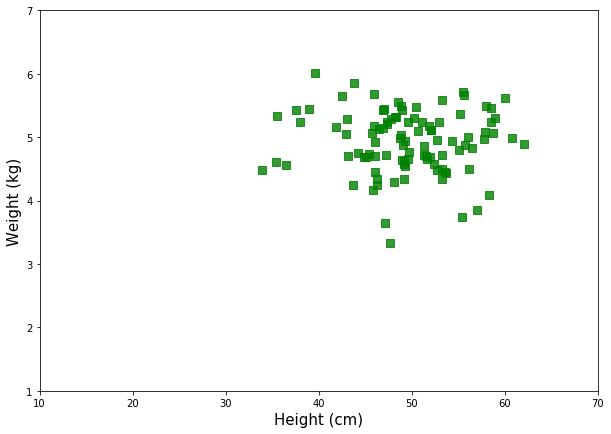

In [2]:
# 100个正态分布的悲伤
grief_heights = np.random.normal(50, 6, 100)
grief_weights = np.random.normal(5, 0.5, 100)

# 设置图片大小
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 7

plt.scatter(grief_heights,grief_weights,c='g',marker='s',s=50,alpha=0.8)
plt.axis((10, 70,1,7))
plt.xlabel('Height (cm)',size=15)
plt.ylabel('Weight (kg)', size=15)
plt.show()

还有一种兔子呢，叫作痛苦（Agony）。它们体型比较小，平均身高是30厘米，平均体重是4公斤。我们将一百个痛苦的身高和体重画在同一个坐标图上，用蓝色三角表示。

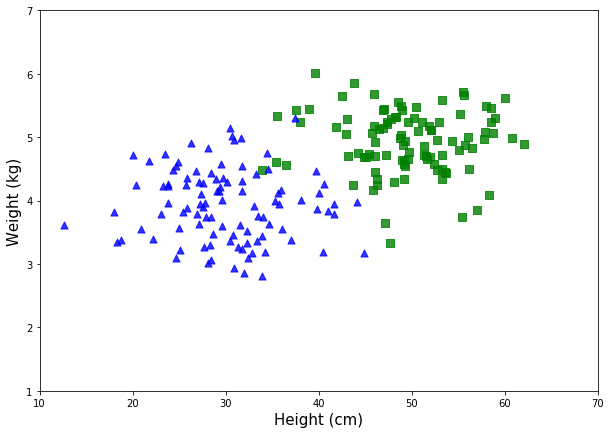

In [3]:
# 100个正态分布的痛苦
agony_heights = np.random.normal(30,6,100)
agony_weights = np.random.normal(4,0.5,100)

plt.scatter(grief_heights,grief_weights,c='g',marker='s',s=50,alpha=0.8)
plt.scatter(agony_heights,agony_weights,c='b',marker='^',s=50,alpha=0.8)
plt.axis((10, 70,1,7))
plt.xlabel('Height (cm)',size=15)
plt.ylabel('Weight (kg)', size=15)
plt.show()

最后一种兔子叫绝望（Despair）。它们的平均身高45厘米，但体重较轻，平均只有2.5公斤。一百只绝望的数据用黄色圆圈表示。

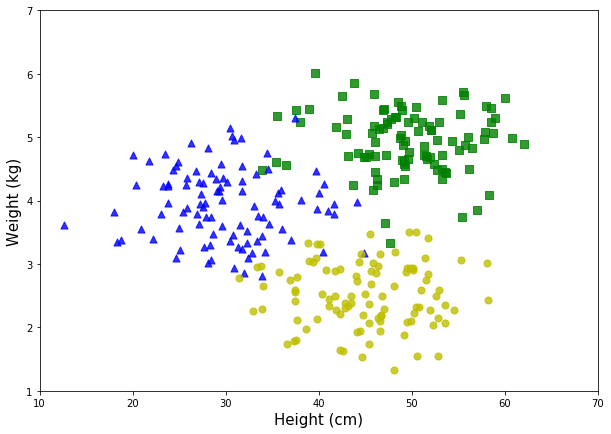

In [4]:
# 100个正态分布的绝望
despair_heights = np.random.normal(45,6,100)
despair_weights = np.random.normal(2.5, 0.5, 100)

plt.scatter(grief_heights,grief_weights,c='g',marker='s',s=50,alpha=0.8)
plt.scatter(agony_heights,agony_weights,c='b',marker='^',s=50,alpha=0.8)
plt.scatter(despair_heights,despair_weights, c='y', s=50, alpha=0.8)
plt.axis((10, 70,1,7))
plt.xlabel('Height (cm)',size=15)
plt.ylabel('Weight (kg)', size=15)
plt.show()

在这些数据中，(身高,体重)的二元组叫做特征（features），兔子的品种则是分类标签（class label）。我们想解决的问题是，给定一个未知分类的新样本的所有特征，通过已知数据来判断它的类别。

北京十八环外有一个小树林里经常出现这三种兔子。为了了解它们的生态环境，某研究团队想知道三种兔子的数量比例；可是这些兔子又太过危险，不能让人亲自去做，所以要设计一个全自动的机器人，让它自己去树林里识别它遇到的每一个兔子的种类。啊，为了把故事讲圆，还要假设他们经费不足，所以机器只有测量兔子的身高和体重的能力。

那么现在有一迷之兔子，我们想判断它的类别，要怎么做呢？按照最普通的直觉，应该在已知数据里找出几个和我们想探究的兔子最相似的几个点，然后看看那些兔子都是什么个情况；如果它们当中大多数都属于某一类别，那么迷之兔子大概率也就是那个类别了。

于是乎，我们给机器人预设一个整数$k$，让它去寻找距离最近的$k$个数据样本进行分析。好，机器发现了一只兔子，它长着八条腿，三十二只眼睛，毛茸茸的小尾巴，齐刷刷的八十六颗獠牙，面相狰狞，散发着噩梦般的腐臭，发出来自地狱底处的咆哮… 差不多就是这个样子（作者手绘）：

<img src="images/01.png" style="width:600px;"/>

可我们的机器才识别不了那么多，它只测量出这只兔子身长40厘米，体重2.7公斤，就是下面图中那颗闪闪发亮的红星：

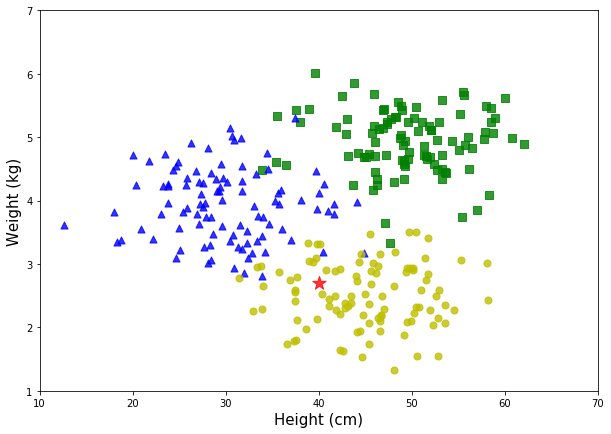

In [5]:
plt.scatter(40,2.7, c='r', s=200, marker='*',alpha=0.8)
plt.scatter(grief_heights,grief_weights,c='g',marker='s',s=50,alpha=0.8)
plt.scatter(agony_heights,agony_weights,c='b',marker='^',s=50,alpha=0.8)
plt.scatter(despair_heights,despair_weights, c='y', s=50, alpha=0.8)
plt.axis((10, 70,1,7))
plt.xlabel('Height (cm)',size=15)
plt.ylabel('Weight (kg)', size=15)
plt.show()

kNN 算法如何对这次观测进行分类要取决于$k$的大小。直觉告诉我们迷之兔像是一只绝望，因为除了最近的蓝色三角外，附近其他都是黄色圆圈。的确，如果设$k=15$，算法会判断这只兔子是一只绝望。但是如果设$k=1$，那么由于距离最近的是蓝色三角，会判断迷之兔子是一只痛苦。

如果按照15NN和1NN的方法对这个二维空间上的每一个点进行分类，会形成以下的分割：

In [6]:
# 以下是kd树算法，可以直接拿去用。下一篇文章会进行详细的讲解
class kdtree(object):
    
    # 创建 kdtree 喵
    # point_list 是一个 list 的 pair，pair[0] 是一 tuple 的特征，pair[1] 是类别
    def __init__(self, point_list, depth=0, root=None):
        
        if len(point_list)>0:
            
            # 轮换按照树深度选择坐标轴
            k = len(point_list[0][0])
            axis = depth % k
            
            # 选中位线，切
            point_list.sort(key=lambda x:x[0][axis])
            median = len(point_list) // 2
            
            self.axis = axis
            self.root = root
            self.size = len(point_list)
            
            # 造节点
            self.node = point_list[median]
            # 递归造左枝和右枝
            if len(point_list[:median])>0:
                self.left = kdtree(point_list[:median], depth+1, self)
            else:
                self.left = None
            if len(point_list[median+1:])>0:
                self.right = kdtree(point_list[median+1:], depth+1, self)
            else:
                self.right = None
            # 记录是按哪个方向切的还有树根

        else:
            return None
    
    # 在树上加一点
    def insert(self, point):
        self.size += 1
        
        # 分析是左还是右，递归加在叶子上
        if point[0][self.axis]<self.node[0][self.axis]:
            if self.left!=None:
                self.left.insert(point)
            else:
                self.left = kdtree([point], self.axis+1, self)
        else:
            if self.right!=None:
                self.right.insert(point)
            else:
                self.right = kdtree([point], self.axis+1, self)
            
            
    # 输入一点
    # 按切分寻找叶子
    def find_leaf(self, point):
        if self.left==None and self.right==None:
            return self
        elif self.left==None:
            return self.right.find_leaf(point)
        elif self.right==None:
            return self.left.find_leaf(point)
        elif point[self.axis]<self.node[0][self.axis]:
            return self.left.find_leaf(point)
        else:
            return self.right.find_leaf(point)
        

    # 查找最近的 k 个点，复杂度 O(DlogN)，D是维度，N是树的大小
    # 输入一点、一距离函数、一k。距离函数默认是 L_2
    def knearest(self, point, k=1, dist=lambda x,y: sum(map(lambda u,v:(u-v)**2,x,y))):
        # 往下戳到最底叶
        leaf = self.find_leaf(point)
        # 从叶子网上爬
        return leaf.k_down_up(point, k, dist, result=[], stop=self, visited=None)


    # 从下往上爬函数，stop是到哪里去，visited是从哪里来
    def k_down_up(self, point,k, dist, result=[],stop=None, visited=None):

        # 选最长距离
        if result==[]:
            max_dist = 0
        else:
            max_dist = max([x[1] for x in result])

        other_result=[]

        # 如果离分界线的距离小于现有最大距离，或者数据点不够，就从另一边的树根开始刨
        if (self.left==visited and self.node[0][self.axis]-point[self.axis]<max_dist and self.right!=None)\
            or (len(result)<k and self.left==visited and self.right!=None):
            other_result=self.right.knearest(point,k, dist)

        if (self.right==visited and point[self.axis]-self.node[0][self.axis]<max_dist and self.left!=None)\
            or (len(result)<k and self.right==visited and self.left!=None):
            other_result=self.left.knearest(point, k, dist)

        # 刨出来的点放一起，选前 k 个
        result.append((self.node, dist(point, self.node[0])))
        result = sorted(result+other_result, key=lambda pair: pair[1])[:k]

        # 到停点就返回结果
        if self==stop:
            return result
        # 没有就带着现有结果接着往上爬
        else:
            return self.root.k_down_up(point,k,  dist, result, stop, self)

    # 输入 特征、类别、k、距离函数
    # 返回这个点属于该类别的概率
    def kNN_prob(self, point, label, k, dist=lambda x,y: sum(map(lambda u,v:(u-v)**2,x,y))):
        nearests = self.knearest(point,  k, dist)
        return float(len([pair for pair in nearests if pair[0][1]==label]))/float(len(nearests))


    # 输入 特征、k、距离函数
    # 返回该点概率最大的类别以及相对应的概率
    def kNN(self, point, k, dist=lambda x,y: sum(map(lambda u,v:(u-v)**2,x,y))):
        nearests = self.knearest(point, k , dist)

        statistics = {}
        for data in nearests:
            label = data[0][1]
            if label not in statistics: 
                statistics[label] = 1
            else:
                statistics[label] += 1

        max_label = max(statistics.items(), key=operator.itemgetter(1))[0]
        return max_label, float(statistics[max_label])/float(len(nearests))

In [7]:
# 设置样本集
grieves = list(map(lambda x,y:tuple(((x,y),'g')),grief_heights, grief_weights))
agonies = list(map(lambda u,v:tuple(((u,v),'b')),agony_heights, agony_weights))
despairs = list(map(lambda a,b:tuple(((a,b),'y')),despair_heights, despair_weights))

# 创建kd树
tree = kdtree(list(np.concatenate((grieves,agonies,despairs))))

# 穷举生成空间上的点
all_points = []
for i in range(100,701):
    for j in range(100,701):
        all_points.append((float(i)/10., float(j)/100.))
        
# 一共是36万个点
len(all_points)

361201

In [8]:
# 设置归一化距离函数
def normalized_dist(x,y):
    return (x[0]-y[0])**2+(10*x[1]-10*y[1])**2

# 每个点运算 15NN，并记录计算时间
now = datetime.datetime.now()
fifteen_NN_result = []
for point in all_points:
    fifteen_NN_result.append((point, tree.kNN(point,k=15, dist=normalized_dist)[0]))
("elapse time: ", datetime.datetime.now() - now)

('elapse time: ', datetime.timedelta(0, 877, 11165))

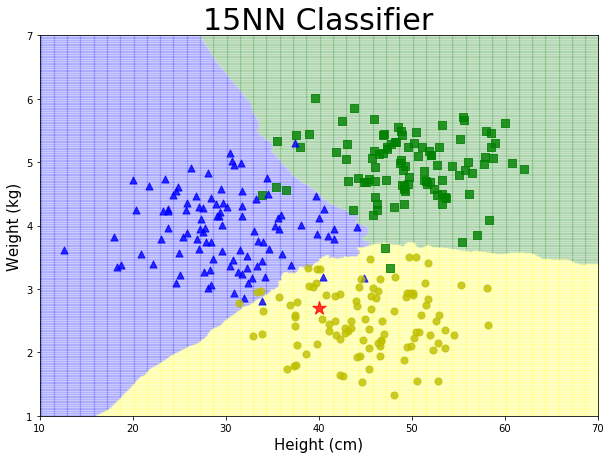

In [9]:
# 把每个颜色的数据分开
fifteen_NN_yellow = []
fifteen_NN_green = []
fifteen_NN_blue = []

for pair in fifteen_NN_result:
    if pair[1]=='y':
        fifteen_NN_yellow.append(pair[0])
    if pair[1]=='g':
        fifteen_NN_green.append(pair[0])
    if pair[1]=='b':
        fifteen_NN_blue.append(pair[0])

plt.scatter(40,2.7, c='r', s=200, marker='*',alpha=0.8, zorder=10)
plt.scatter(grief_heights,grief_weights,c='g',marker='s',s=50,alpha=0.8,zorder=10)
plt.scatter(agony_heights,agony_weights,c='b',marker='^',s=50,alpha=0.8,zorder=10)
plt.scatter(despair_heights,despair_weights, c='y', s=50, alpha=0.8,zorder=10)
plt.scatter([x[0] for x in fifteen_NN_yellow], [x[1] for x in fifteen_NN_yellow], s=1, c='yellow', marker='1', alpha=0.1)
plt.scatter([x[0] for x in fifteen_NN_blue], [x[1] for x in fifteen_NN_blue], s=1, c='blue', marker='2', alpha=0.1)
plt.scatter([x[0] for x in fifteen_NN_green], [x[1] for x in fifteen_NN_green], s=1, c='green', marker='3', alpha=0.1)
plt.axis((10, 70,1,7))
plt.title('15NN Classifier',size=30)
plt.xlabel('Height (cm)',size=15)
plt.ylabel('Weight (kg)', size=15)
plt.show()

In [10]:
# 每个点运算 1NN，并记录计算时间
now = datetime.datetime.now()
one_NN_result = []
for point in all_points:
    one_NN_result.append((point, tree.kNN(point,k=1, dist=lambda x,y: (x[0]-y[0])**2+(10*x[1]-10*y[1])**2)[0]))

("elapse time: ", datetime.datetime.now() - now)

('elapse time: ', datetime.timedelta(0, 541, 101082))

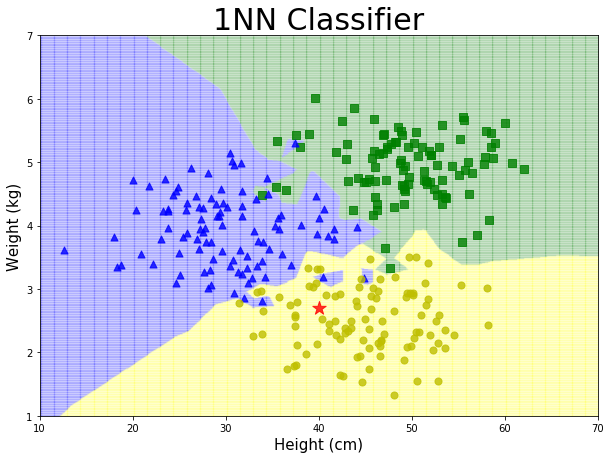

In [11]:
# 把每个颜色的数据分开
one_NN_yellow = []
one_NN_green = []
one_NN_blue = []
for pair in one_NN_result:
    if pair[1]=='y':
        one_NN_yellow.append(pair[0])
    if pair[1]=='g':
        one_NN_green.append(pair[0])
    if pair[1]=='b':
        one_NN_blue.append(pair[0])
        
plt.scatter(40,2.7, c='r', s=200, marker='*',alpha=0.8, zorder=10)
plt.scatter(grief_heights,grief_weights,c='g',marker='s',s=50,alpha=0.8,zorder=10)
plt.scatter(agony_heights,agony_weights,c='b',marker='^',s=50,alpha=0.8,zorder=10)
plt.scatter(despair_heights,despair_weights, c='y', s=50, alpha=0.8,zorder=10)
plt.scatter([x[0] for x in one_NN_yellow], [x[1] for x in one_NN_yellow], s=1, c='yellow', marker='1', alpha=0.1)
plt.scatter([x[0] for x in one_NN_blue], [x[1] for x in one_NN_blue], s=1, c='blue', marker='2', alpha=0.1)
plt.scatter([x[0] for x in one_NN_green], [x[1] for x in one_NN_green], s=1, c='green', marker='3', alpha=0.1)
plt.axis((10, 70,1,7))
plt.title('1NN Classifier',size=30)
plt.xlabel('Height (cm)',size=15)
plt.ylabel('Weight (kg)', size=15)
plt.show()

在两组分类中，1NN 的分类边界明显更“崎岖”，但是对历史样本没有误判；而 15NN 的分类边界更平滑，但是对历史样本有发生误判的现象。选择$k$的大小取决于对偏差和方差之间的权衡，本篇不进行更深探讨，读者在使用 kNN 时凭感觉选一个$k$就好。

## 距离函数
我们在上面的例子中把一个很重要的概念隐藏了起来，在选择一个数量$k$还只是小问题，更重要的是距离的计算方法。毕竟，当我们说“最近的$k$个点”时，这个“近”是怎么衡量的？

在数学中，一个空间上距离的严格定义如下：
设$M$为一个空间，$M$上的一个距离函数是一个函数$d:M×M \to \mathbb R$，满足：

+ $d(x,y) \geqslant 0 \ \ \forall \ \ x,y \in M$
+ $d(x,y) = 0 \ \ \Longleftrightarrow \ \ x=y$
+ $d(x,y)=d(y,x) \ \ \forall \ \ x,y \in M$
+ $d(x,z) \leqslant d(x,y)+d(y,z) \ \ \forall \ \ x,y,z \in M$

两个点$x,y$之间的距离就是$d(x,y)$。

我们一般最常用的距离函数是欧氏距离，也称作$L_2$距离。如果$x = (x_1,x_2,…,x_n)$和$y=(y_1,y_2,…,y_n)$是$n$维欧式空间$\mathbb{R}^n$上的两个点，那它们之间的$L_2$距离是：

+ $\displaystyle d_2(x,y) = \sqrt{\sum_{i=1}^{n}(x_i−y_i)^2}$

$L_2$是更普遍的$L_p$距离在$p=2$时的特例。$L_p$距离的函数$d_p$定义如下：对于$1 ≤ p < \infty$，有
+ $\displaystyle d_p(x,y) = (\sum_{i=1}^{n}|x_i−y_i|^p)^{\frac{1}{p}}$

还有$L_{\infty}$距离 
+ $\displaystyle d_{\infty}(x,y) = \max_{i=1, \dots, n} |x_i - y_i|$

在实际应用中，距离函数的选择应该根据数据的特性和分析的需要而定，本篇就不进行更深入的探讨，一般情况下使用最常用的$L_2$函数即可。

但是！注意！使用 kNN 时需要根据特征数据的取值区间来调整坐标轴的比例，这个做法叫作标准化或者归一化。为什么要这么做呢？拿上面的例子来说，一只兔子的身长（cm）数值平均是它的体重（kg）的10倍左右，如果我们在这组数值上直接使用$l_2$距离函数的话就会导致横轴的距离比重明显放大，分类结果也不合理，如下图所示：

In [12]:
# 使用未归一化的距离计算 15NN
now = datetime.datetime.now()
bad_NN_result = []
for point in all_points:
    bad_NN_result.append((point, tree.kNN(point,k=15)[0]))

("elapse time: ", datetime.datetime.now() - now)

('elapse time: ', datetime.timedelta(0, 685, 599500))

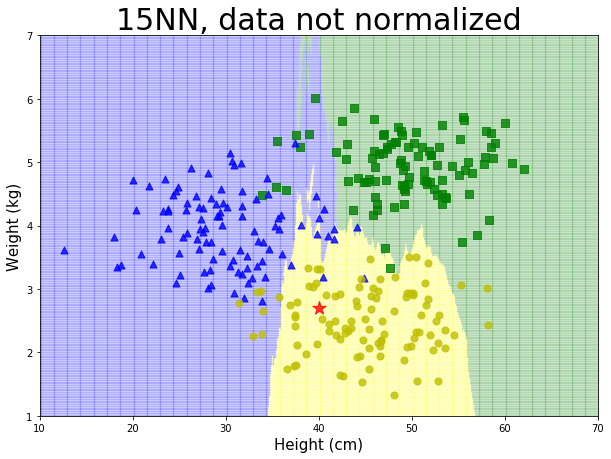

In [13]:
# 把每个颜色的数据分开
bad_NN_yellow = []
bad_NN_green = []
bad_NN_blue = []
for pair in bad_NN_result:
    if pair[1]=='y':
        bad_NN_yellow.append(pair[0])
    if pair[1]=='g':
        bad_NN_green.append(pair[0])
    if pair[1]=='b':
        bad_NN_blue.append(pair[0])

plt.scatter(40,2.7, c='r', s=200, marker='*',alpha=0.8, zorder=10)
plt.scatter(grief_heights,grief_weights,c='g',marker='s',s=50,alpha=0.8,zorder=10)
plt.scatter(agony_heights,agony_weights,c='b',marker='^',s=50,alpha=0.8,zorder=10)
plt.scatter(despair_heights,despair_weights, c='y', s=50, alpha=0.8,zorder=10)
plt.scatter([x[0] for x in bad_NN_yellow], [x[1] for x in bad_NN_yellow], s=1, c='yellow', marker='1', alpha=0.1)
plt.scatter([x[0] for x in bad_NN_blue], [x[1] for x in bad_NN_blue], s=1, c='blue', marker='2', alpha=0.1)
plt.scatter([x[0] for x in bad_NN_green], [x[1] for x in bad_NN_green], s=1, c='green', marker='3', alpha=0.1)
plt.axis((10, 70,1,7))
plt.title('15NN, data not normalized',size=30)
plt.xlabel('Height (cm)',size=15)
plt.ylabel('Weight (kg)', size=15)
plt.show()

如果把坐标轴成其他的单位，比如毫米和吨，并用相应的新数值来计算距离，又会得到完全不同的分类标准。甚至，在极端情况下，如果身高用纳米并且体重用吨计量，那么相比之下身高的数值会奇高无比，以至于两点之间的距离是完全由身高决定的，体重则没有任何权重。为了解决这个问题，我们应该在计算距离时把所有坐标轴进行归一化。

在之前的例子中，由于横轴数值大约是竖轴的10倍左右，所以我们将横轴（身高）的数值压缩10倍，即计算距离时使用：
+ $\displaystyle d((x1,x2),(y1,y2))=\sqrt{(\frac{x_1}{10} - \frac{y_1}{10})^2+(x_2 - y_2)^2}$

就可以得出合理的 kNN 分类。

一般来说，假设进行 kNN 分类使用的样本的特征是${(x_{i1},x_{i2}, \dots, x_{in})}_{i=1}^m$，取每一轴上的最大值减最小值：
+ $\displaystyle M_j =  \max_{i=1,2,\dots,m}x_{ij} - \min_{i=1,2,\dots,m}x_{ij}$

并且在计算距离时将每一个坐标轴除以相应的$M_j$以进行归一化，即：
+ $\displaystyle d((y_1,\dots,y_n),(z_1,\dots,z_n))=\sqrt{\sum_{j=1}^{n}(\frac{y_j}{M-j}-\frac{z_j}{M-j})^2}$

便可以规避坐标轴比例失衡的问题。

## 概率 KNN
上面的kNN算法返回的是对一组特征的绝对分类，告诉我们这只兔子被判断为哪一个类别。可有时我们并不想知道一个确切地分类，而想知道它属于某个分类的概率是多大。比如我们发现一只身长37体重4.8的小兔兔，在下图五角星的位置。

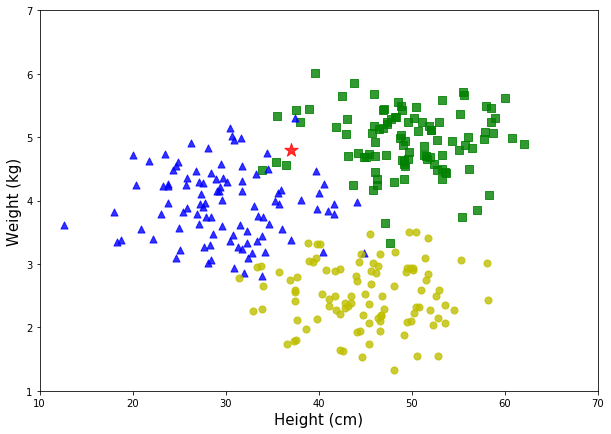

In [14]:
plt.scatter(37,4.8, c='r', s=200, marker='*',alpha=0.8,zorder=10)
plt.scatter(grief_heights,grief_weights,c='g',marker='s',s=50,alpha=0.8)
plt.scatter(agony_heights,agony_weights,c='b',marker='^',s=50,alpha=0.8)
plt.scatter(despair_heights,despair_weights, c='y', s=50, alpha=0.8)
plt.axis((10, 70,1,7))
plt.xlabel('Height (cm)',size=15)
plt.ylabel('Weight (kg)', size=15)
plt.show()

这只兔子的特征数据在悲伤和痛苦的分界处，机器不论判断它属于哪个类别都很有可能是错的。这时，类似“它有一半可能性是痛苦，一半可能性是悲伤”的反馈会更有意义。

为了这个目的，我们同样找出距离问题特征最近的$k$个样本，但与其寻找数量最多的分类，我们统计其中每个类别的分别有多少个，再除以$k$得到一个属于每一个类别概率值。比如在上面的图里，距离五角星最近的15个样本中，有8只悲伤和7只痛苦，由此判断：它有$53%$的可能性是悲伤，$47%$的可能性是痛苦，$0%$的可能性是绝望。

在整个二维空间中的每一个点上进行概率 kNN 算法，可以得到每个特征点是属于某个类别的概率热力图，图中颜色越深代表概率越大。

In [15]:
# 15NN 计算是悲伤的概率
now = datetime.datetime.now()
grief_prob = []
for point in all_points:
    grief_prob.append((point, tree.kNN_prob(point, label='g', k=15, dist=normalized_dist)))

("elapse time: ", datetime.datetime.now() - now)

('elapse time: ', datetime.timedelta(0, 914, 249427))

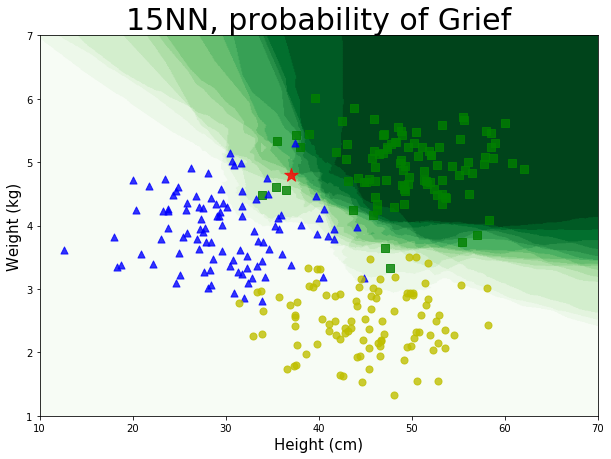

In [16]:
plt.scatter(37,4.8, c='r', s=200, marker='*',alpha=0.8,zorder=10)
plt.scatter(grief_heights,grief_weights,c='g',marker='s',s=50,alpha=0.8,zorder=10)
plt.scatter(agony_heights,agony_weights,c='b',marker='^',s=50,alpha=0.8,zorder=10)
plt.scatter(despair_heights,despair_weights, c='y', s=50, alpha=0.8,zorder=10)
plt.scatter([x[0][0] for x in grief_prob], [x[0][1] for x in grief_prob], s=1, c=[x[1] for x in grief_prob], marker='1',cmap='Greens')
plt.axis((10, 70,1,7))
plt.title('15NN, probability of Grief',size=30)
plt.xlabel('Height (cm)',size=15)
plt.ylabel('Weight (kg)', size=15)
plt.show()

In [17]:
# 15NN 计算是痛苦的概率
now = datetime.datetime.now()
agony_prob = []
for point in all_points:
    agony_prob.append((point, tree.kNN_prob(point, label='b', k=15, dist=normalized_dist)))

("elapse time: ", datetime.datetime.now() - now)

('elapse time: ', datetime.timedelta(0, 597, 108186))

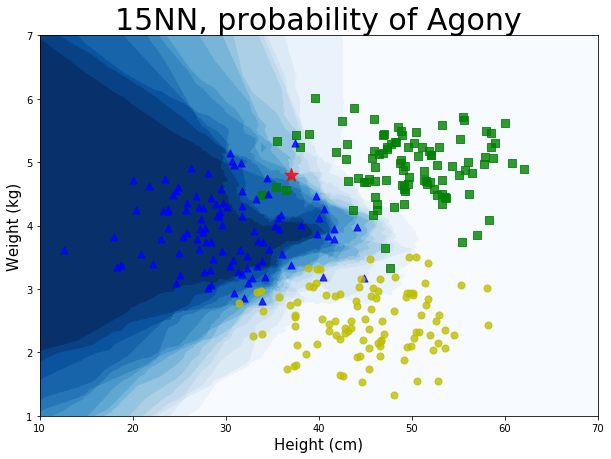

In [18]:
plt.scatter(37,4.8, c='r', s=200, marker='*',alpha=0.8,zorder=10)
plt.scatter(grief_heights,grief_weights,c='g',marker='s',s=50,alpha=0.8,zorder=10)
plt.scatter(agony_heights,agony_weights,c='b',marker='^',s=50,alpha=0.8,zorder=10)
plt.scatter(despair_heights,despair_weights, c='y', s=50, alpha=0.8,zorder=10)
plt.scatter([x[0][0] for x in agony_prob], [x[0][1] for x in agony_prob], s=1, c=[x[1] for x in agony_prob], marker='1',cmap='Blues')
plt.axis((10, 70,1,7))
plt.title('15NN, probability of Agony',size=30)
plt.xlabel('Height (cm)',size=15)
plt.ylabel('Weight (kg)', size=15)
plt.show()

In [19]:
# 15NN 计算是绝望的概率
now = datetime.datetime.now()
despair_prob = []
for point in all_points:
    despair_prob.append((point, tree.kNN_prob(point, label='y', k=15, dist=normalized_dist)))

("elapse time: ", datetime.datetime.now() - now)

('elapse time: ', datetime.timedelta(0, 811, 616755))

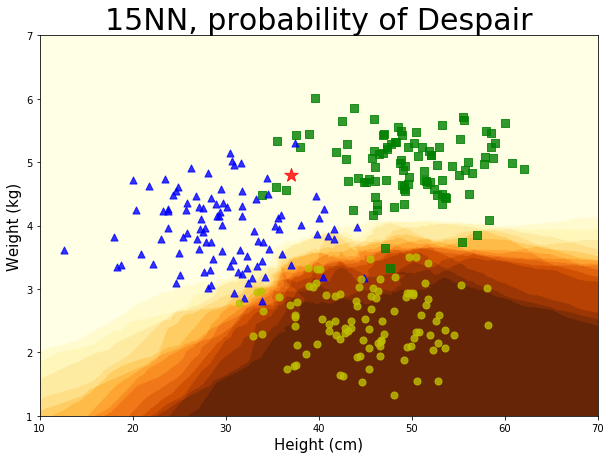

In [20]:
plt.scatter(37,4.8, c='r', s=200, marker='*',alpha=0.8,zorder=10)
plt.scatter(grief_heights,grief_weights,c='g',marker='s',s=50,alpha=0.8,zorder=10)
plt.scatter(agony_heights,agony_weights,c='b',marker='^',s=50,alpha=0.8,zorder=10)
plt.scatter(despair_heights,despair_weights, c='y', s=50, alpha=0.8,zorder=10)
plt.scatter([x[0][0] for x in despair_prob], [x[0][1] for x in despair_prob], s=1, c=[x[1] for x in despair_prob], marker='1',cmap='YlOrBr')
plt.axis((10, 70,1,7))
plt.title('15NN, probability of Despair',size=30)
plt.xlabel('Height (cm)',size=15)
plt.ylabel('Weight (kg)', size=15)
plt.show()

相比于绝对的分类，这些概率的计算会给我们更有效的表述以及更多的应用空间。比如说，我们知道悲伤兔子喜欢向我们的机器人上喷洒奇怪的粘液，毫无作用毫无意义的绿色的粘液，就像这样（作者手绘）：

<img src="images/02.png" style="width:600px;"/>

倒不是因为别的，我们就是觉得这种粘液很恶心，清洗起来也很麻烦，所以我们想让机器人在测量并发现是悲伤之后马上掉头逃跑。但是如果机器发现了一只体型接近痛苦的悲伤，并且普通的 kNN 算法发生误判，没有马上逃跑，那么最后就会被喷了。所以我们使用概率 kNN 的算法并且使用以下风控原则：只要发现兔子有 $30%$ 以上的概率是悲伤，就马上逃跑。从此之后，机器人就再也没被喷过。

## 结语
不知你有没有发现，我跟你讲了这么多关于兔子的事，却丝毫没有提及如何用代码计算 kNN。这是因为 kNN 虽然思路简单，但实现起来有一个问题，那就是计算量很大；当数据量很多时，拿一组特征来和所有样本依次计算距离并选取最近的$k$个，是非常耗费时间的。所以，在量化课堂接下来的文章中，我们将讲解 kNN 的一个高效算法—kd树。